In [1]:
import sys
## import all the packages needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
## read NHANES dataset
df = pd.read_csv('/Users/zhiyi/Desktop/for Yupei/CS.csv')

In [3]:
## find all the distinct values of os
df.os.value_counts()

0    15392
1     4256
Name: os, dtype: int64

In [4]:
## data preparation
# exclude null values and NA
df = df[df.os.notnull()]
# check os
df.os.describe()

count    19648.000000
mean         0.216612
std          0.411947
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: os, dtype: float64

In [5]:
# exclude non-numeric values
d = df.select_dtypes(['number'])

# exclude columns that have over 50% NaN
d = d.dropna(thresh = 0.5*len(d), axis =1)

print(len(d.columns), 'columns are left')

21 columns are left


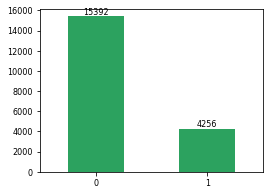

In [6]:
## plot the distribution of values of response variable
vals = d.os.value_counts()

plt.figure(figsize=(4,3))
plt.rc('font', size=8)

ax = vals.plot.bar(rot=0, color='#2ca25f')
for i in range(len(vals)):
    ax.annotate(vals[i], xy=[vals.index[i], vals[i]], ha='center', va='bottom')

In [7]:
# replace NA with most frequent values
from sklearn.impute import SimpleImputer
imp_mode = SimpleImputer(strategy='most_frequent')

## show the complete dataset
d = pd.DataFrame(imp_mode.fit_transform(d), columns=d.columns)
d 

,os,gender,race,age,size,marry,income,site,grade,kind,...,N,surgery_pri,RX_Summ,radiate,chem,CEA,bone,brain,lung,group
0,1,2,2,3,3,1,3,1,5,1,...,3,0,0,0,0,1,0,0,1,3
1,0,1,1,3,1,3,3,2,2,1,...,2,1,0,0,0,0,0,0,0,1
2,0,2,1,3,3,2,3,2,2,1,...,1,0,0,0,1,1,0,0,0,3
3,0,1,3,3,1,3,3,1,5,1,...,1,0,0,0,0,1,0,0,1,3
4,0,1,2,3,3,2,3,1,2,1,...,1,0,0,0,1,2,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19643,0,2,1,2,3,2,2,1,5,1,...,3,0,0,0,0,1,0,0,1,3
19644,1,2,2,3,3,2,2,1,5,1,...,1,0,0,0,0,2,0,0,0,3
19645,0,1,1,2,1,2,1,1,5,1,...,3,0,0,1,1,1,0,0,0,3
19646,0,2,1,2,3,3,2,1,5,1,...,3,1,0,0,0,2,0,0,0,3


In [8]:
## separate predictors and responses
X = d.loc[:, d.columns != 'os']
y = d.os
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (19648, 20)
y shape: (19648,)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

def confusion(y_test, y_pred):
    conf = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
    print('Confusion Matrix:')
    print(conf)
    return conf

confusion(y_test, y_pred) 

Accuracy: 80.33%
Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2792         264
True[1]         509         365


,Predict[0],Predict[1]
True[0],2792,264
True[1],509,365


In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
X_test_sm, y_test_sm = smote.fit_resample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

print(y_train_sm.value_counts())
print(y_test_sm.value_counts())

1    12336
0    12336
Name: os, dtype: int64
0    3056
1    3056
Name: os, dtype: int64


In [12]:
# After oversampling, the classification result is more reasonable.
model = XGBClassifier()
model.fit(X_train_sm, y_train_sm)
y_pred_sm = model.predict(X_test_sm)

accuracy = accuracy_score(y_test_sm, y_pred_sm)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
conf = pd.DataFrame(confusion_matrix(y_test_sm, y_pred_sm), index=['True[0]', 'True[1]'], columns=['Predict[0]', 'Predict[1]'])
conf

Accuracy: 76.62%


,Predict[0],Predict[1]
True[0],2422,634
True[1],795,2261


In [13]:
X_scale = d.loc[:, d.columns != 'os']
y = d.os

In [14]:
## min-max scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
X = pd.DataFrame(minmax.fit_transform(X_scale), columns=X_scale.columns)
X

,gender,race,age,size,marry,income,site,grade,kind,T,N,surgery_pri,RX_Summ,radiate,chem,CEA,bone,brain,lung,group
0,1.0,0.5,1.0,1.0,0.0,1.0,0.0,1.00,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0
1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.25,0.0,0.5,0.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,1.0,0.5,1.0,1.0,0.25,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.00,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0
4,0.0,0.5,1.0,1.0,0.5,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19643,1.0,0.0,0.5,1.0,0.5,0.5,0.0,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,1.0
19644,1.0,0.5,1.0,1.0,0.5,0.5,0.0,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
19645,0.0,0.0,0.5,0.0,0.5,0.0,0.0,1.00,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.5,0.0,0.0,0.0,1.0
19646,1.0,0.0,0.5,1.0,1.0,0.5,0.0,1.00,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [15]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=12)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
#X_test_sm, y_test_sm = smote.fit_sample(X_test, y_test)

X_train_sm = pd.DataFrame(X_train_sm, columns=X.columns)
#X_test_sm = pd.DataFrame(X_test_sm, columns=X.columns)

In [17]:
print('X train shape: ',X_train_sm.shape)
print('y train values: \n', y_train_sm.value_counts())
print()
print('X test shape: ',X_test_sm.shape)
print('y test values: \n', y_test_sm.value_counts())

X train shape:  (24672, 20)
y train values: 
 1    12336
0    12336
Name: os, dtype: int64

X test shape:  (6112, 20)
y test values: 
 0    3056
1    3056
Name: os, dtype: int64


In [18]:
mscore=[]

In [19]:
from sklearn.linear_model import LogisticRegression
from time import process_time

clf = LogisticRegression(max_iter=100, solver='lbfgs', class_weight='balanced', random_state=12)

start = process_time()
clf.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

clf_prediction_proba = clf.predict_proba(X_test)[:, 1]

y_pred = clf.predict(X_test)

print('Accuracy Score:', clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Logistic Regression', clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

0.18044000000000082
Accuracy Score: 0.7592875318066158
Prediction: [0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3056
           1       0.47      0.70      0.57       874

    accuracy                           0.76      3930
   macro avg       0.69      0.74      0.70      3930
weighted avg       0.81      0.76      0.77      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2368         688
True[1]         258         616


,Predict[0],Predict[1]
True[0],2368,688
True[1],258,616


In [20]:
from sklearn.ensemble import RandomForestClassifier
from time import process_time

rnd_clf = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=12)

start = process_time()
model = rnd_clf.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

rf_prediction_proba = rnd_clf.predict_proba(X_test)[:, 1]

y_pred = rnd_clf.predict(X_test)

print('Accuracy Score:', rnd_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Random Forest', rnd_clf.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

2.7347050000000017
Accuracy Score: 0.789058524173028
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      3056
           1       0.53      0.43      0.47       874

    accuracy                           0.79      3930
   macro avg       0.69      0.66      0.67      3930
weighted avg       0.78      0.79      0.78      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2727         329
True[1]         500         374
       Variable  Importance
14         chem    0.205154
7         grade    0.091922
2           age    0.080710
4         marry    0.070751
5        income    0.064811
3          size    0.060049
18         lung    0.056253
15          CEA    0.054175
9             T    0.053338
1          race    0.041704
10            N    0.035928
19        group    0.032703
0        gender    0.031439
6          site    0.029272
16         bone    0.021990
11  surgery_pri    0.017856


In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from time import process_time

bagging = BaggingClassifier(base_estimator= DecisionTreeClassifier(random_state=12), max_samples = 1.0, max_features = 1.0, 
                            bootstrap = True, bootstrap_features = False, random_state=12)

start = process_time()
bagging.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

bg_prediction_proba = bagging.predict_proba(X_test)[:, 1]

y_pred = bagging.predict(X_test)

print('Accuracy Score:', bagging.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Bagging DecisionTree', bagging.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

0.6984320000000004
Accuracy Score: 0.7699745547073792
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      3056
           1       0.48      0.39      0.43       874

    accuracy                           0.77      3930
   macro avg       0.66      0.64      0.64      3930
weighted avg       0.76      0.77      0.76      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2682         374
True[1]         530         344


,Predict[0],Predict[1]
True[0],2682,374
True[1],530,344


In [22]:
from sklearn.neighbors import KNeighborsClassifier
from time import process_time

knn = KNeighborsClassifier()

start = process_time()
knn.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

knn_prediction_proba = knn.predict_proba(X_test)[:, 1]

y_pred = knn.predict(X_test)

print('Accuracy Score:', knn.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['KNN', knn.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

0.007623999999999853
Accuracy Score: 0.6961832061068702
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.88      0.71      0.78      3056
           1       0.39      0.66      0.49       874

    accuracy                           0.70      3930
   macro avg       0.64      0.68      0.64      3930
weighted avg       0.77      0.70      0.72      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2155         901
True[1]         293         581


,Predict[0],Predict[1]
True[0],2155,901
True[1],293,581


In [23]:
from sklearn.naive_bayes import GaussianNB
from time import process_time

gnb = GaussianNB()

start = process_time()
gnb.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

gnb_prediction_proba = gnb.predict_proba(X_test)[:, 1]

y_pred = gnb.predict(X_test)

print('Accuracy Score:', gnb.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Gaussian Naive Bayes', gnb.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

0.01813399999999632
Accuracy Score: 0.6826972010178117
Prediction: [0 1 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.89      0.67      0.77      3056
           1       0.39      0.72      0.50       874

    accuracy                           0.68      3930
   macro avg       0.64      0.70      0.63      3930
weighted avg       0.78      0.68      0.71      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2053        1003
True[1]         244         630


,Predict[0],Predict[1]
True[0],2053,1003
True[1],244,630


In [24]:
from sklearn.ensemble import GradientBoostingClassifier
from time import process_time

gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state=12)

start = process_time()
model = gbc.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

gbc_prediction_proba = gbc.predict_proba(X_test)[:, 1]

y_pred = gbc.predict(X_test)

print('Accuracy Score:', gbc.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Gradient Boosting', gbc.score(X_test, y_test)])

print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

2.5942499999999953
Accuracy Score: 0.8129770992366412
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      3056
           1       0.58      0.55      0.57       874

    accuracy                           0.81      3930
   macro avg       0.73      0.72      0.72      3930
weighted avg       0.81      0.81      0.81      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2715         341
True[1]         394         480
       Variable  Importance
14         chem    0.433358
7         grade    0.102839
2           age    0.087997
18         lung    0.059656
4         marry    0.047998
9             T    0.044653
5        income    0.044059
15          CEA    0.042455
3          size    0.038965
11  surgery_pri    0.031851
19        group    0.025899
16         bone    0.010312
1          race    0.007346
10            N    0.006314
12      RX_Summ    0.005013
6          site    0.004589

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from time import process_time

ada = AdaBoostClassifier(learning_rate=1.0, n_estimators=50, random_state=12)

start = process_time()
model = ada.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

ada_prediction_proba = ada.predict_proba(X_test)[:, 1]

y_pred = ada.predict(X_test)

print('Accuracy Score:', ada.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['Adaptive Boosting', ada.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

0.8218000000000032
Accuracy Score: 0.8048346055979644
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      3056
           1       0.56      0.58      0.57       874

    accuracy                           0.80      3930
   macro avg       0.72      0.73      0.72      3930
weighted avg       0.81      0.80      0.81      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2653         403
True[1]         364         510
       Variable  Importance
5        income        0.22
4         marry        0.20
18         lung        0.12
15          CEA        0.12
2           age        0.08
3          size        0.06
16         bone        0.06
7         grade        0.04
10            N        0.02
14         chem        0.02
6          site        0.02
11  surgery_pri        0.02
12      RX_Summ        0.02
17        brain        0.00
0        gender        0.00
13      radiate        0.00

In [26]:
from sklearn.svm import SVC
from time import process_time

svm_clf = SVC(kernel='rbf', gamma='scale', probability=True, random_state=12)

start = process_time()
svm_clf.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

svm_prediction_proba = svm_clf.predict_proba(X_test)[:, 1]

y_pred = svm_clf.predict(X_test)

print('Accuracy Score:', svm_clf.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['SVM', svm_clf.score(X_test, y_test)])

# from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)

234.605689
Accuracy Score: 0.7580152671755725
Prediction: [0 1 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.90      0.78      0.83      3056
           1       0.47      0.70      0.56       874

    accuracy                           0.76      3930
   macro avg       0.68      0.74      0.70      3930
weighted avg       0.80      0.76      0.77      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2371         685
True[1]         266         608


,Predict[0],Predict[1]
True[0],2371,685
True[1],266,608


In [27]:
from xgboost import XGBClassifier
from time import process_time

xgbc = XGBClassifier(eta=0.3, max_depth=6, random_state=12)

start = process_time()
model = xgbc.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

xgbc_prediction_proba = xgbc.predict_proba(X_test)[:, 1]

y_pred = xgbc.predict(X_test)

print('Accuracy Score:', xgbc.score(X_test, y_test))
print('Prediction:', y_pred)

mscore.append(['XGBoost', xgbc.score(X_test, y_test)])

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
confusion(y_test, y_pred)
print(pd.DataFrame({'Variable':X.columns,
              'Importance':model.feature_importances_}).sort_values('Importance', ascending=False))

8.497627000000023
Accuracy Score: 0.8048346055979644
Prediction: [0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      3056
           1       0.58      0.44      0.50       874

    accuracy                           0.80      3930
   macro avg       0.72      0.67      0.69      3930
weighted avg       0.79      0.80      0.79      3930

Confusion Matrix:
         Predict[0]  Predict[1]
True[0]        2778         278
True[1]         489         385
       Variable  Importance
14         chem    0.344881
11  surgery_pri    0.098779
2           age    0.075192
18         lung    0.059739
7         grade    0.049362
15          CEA    0.046022
5        income    0.044570
4         marry    0.041657
9             T    0.040148
16         bone    0.031390
3          size    0.028152
19        group    0.025421
1          race    0.020828
10            N    0.020576
12      RX_Summ    0.020220
13      radiate    0.012359


In [28]:
from sklearn.neural_network import MLPClassifier
from time import process_time

mlp = MLPClassifier(hidden_layer_sizes=(100,), solver='adam', shuffle=True, tol = 0.0001, random_state=12)

start = process_time()
mlp.fit(X_train_sm, y_train_sm)
end = process_time()
print(end - start)

mlp_prediction_proba = mlp.predict_proba(X_test)[:, 1]

mlp_pred_diabetes = mlp.predict(X_test)

print('Accuracy Score:', mlp.score(X_test, y_test))
print('Prediction:', mlp_pred_diabetes)
print("parameter: ", mlp.get_params())

mscore.append(['MLP', mlp.score(X_test, y_test)])

46.838952000000006
Accuracy Score: 0.761323155216285
Prediction: [0 0 0 ... 0 0 0]
parameter:  {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 12, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


/Users/zhiyi/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [29]:
mscore.sort(key=lambda x: x[1], reverse=True)
mscore

[['Gradient Boosting', 0.8129770992366412],
 ['Adaptive Boosting', 0.8048346055979644],
 ['XGBoost', 0.8048346055979644],
 ['Random Forest', 0.789058524173028],
 ['Bagging DecisionTree', 0.7699745547073792],
 ['MLP', 0.761323155216285],
 ['Logistic Regression', 0.7592875318066158],
 ['SVM', 0.7580152671755725],
 ['KNN', 0.6961832061068702],
 ['Gaussian Naive Bayes', 0.6826972010178117]]

Accuracy Score: 

Gradient Boosting: 81.3%
Adaptive Boosting: 80.48%
XGBoost: 80.48%
Random Forest: 78.91%
Bagging DecisionTree: 77.0%
MLP: 76.13%
Logistic Regression: 75.93%
SVM: 75.8%
KNN: 69.62%
Gaussian Naive Bayes: 68.27%


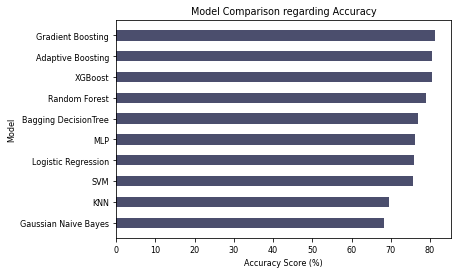

In [30]:
model = list(i[0] for i in mscore)
score = list(round(i[1]*100,2) for i in mscore)

print('Accuracy Score: \n')
for m,s in zip(model, score):
    print(f'{m}: {s}%')

# creating horizontal bar
plt.barh(model, score, height = 0.5, color='#4B4E6D')

plt.xlabel("Accuracy Score (%)")
plt.ylabel("Model")
plt.title("Model Comparison regarding Accuracy")
plt.gca().invert_yaxis()
plt.rc('font', size=9)
plt.show()

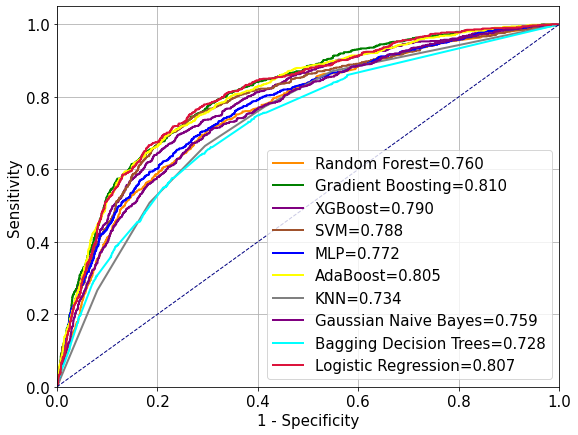

In [31]:
rf_prediction_proba = rnd_clf.predict_proba(X_test)[:, 1]
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 7))
matplotlib.rcParams.update({'font.size': 15})
plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, rf_prediction_proba)
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label='Random Forest={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, gbc_prediction_proba)
plt.plot(fpr, tpr, color='green', lw=2,
         label='Gradient Boosting={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, xgbc_prediction_proba)
plt.plot(fpr, tpr, color='purple', lw=2,
         label='XGBoost={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, svm_prediction_proba)
plt.plot(fpr, tpr, color='sienna', lw=2,
         label='SVM={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, mlp_prediction_proba)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='MLP={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, ada_prediction_proba)
plt.plot(fpr, tpr, color='yellow', lw=2,
         label='AdaBoost={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, knn_prediction_proba)
plt.plot(fpr, tpr, color='grey', lw=2,
         label='KNN={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, gnb_prediction_proba)
plt.plot(fpr, tpr, color='purple', lw=2,
         label='Gaussian Naive Bayes={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, bg_prediction_proba)
plt.plot(fpr, tpr, color='cyan', lw=2,
         label='Bagging Decision Trees={0:.3f}'.format(roc_auc))
fpr, tpr, roc_auc = roc_curve_and_score(y_test, clf_prediction_proba)
plt.plot(fpr, tpr, color='crimson', lw=2,
         label='Logistic Regression={0:.3f}'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()